In [1]:
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from torch.utils.data import DataLoader

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Subset, Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import random
import torchvision.transforms as transforms

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

C:\Users\Moon\Anaconda3\envs\deeplearning\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
""" LeNet architecture implementation
"""
from torch import nn, optim
from torch.autograd import Variable
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels =6, kernel_size= (5,5), padding=2)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels= 16, kernel_size= (5,5))
        self.fc1   = nn.Linear(16*21*26 , 8736)
        self.fc2   = nn.Linear(8736, 84)
        self.fc3   = nn.Linear(84, 40)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2,2))
#         x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = x.view(-1, 16 * 21* 26)
#         print(x.shape)
        # return x
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 2
        for s in size:
            num_features *= s
        return num_features

In [4]:
from torchsummary import summary

model = LeNet()

summary(model, (3, 92, 112))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 6, 92, 112]             456
            Conv2d-2           [-1, 16, 42, 52]           2,416
            Linear-3                 [-1, 8736]      76,326,432
            Linear-4                   [-1, 84]         733,908
            Linear-5                   [-1, 40]           3,400
Total params: 77,066,612
Trainable params: 77,066,612
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.12
Forward/backward pass size (MB): 0.81
Params size (MB): 293.99
Estimated Total Size (MB): 294.91
----------------------------------------------------------------


In [5]:
def weight_inits(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight)
    
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)

In [6]:
def train_model(model, criterion, optimizer, data_loader, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            
            if phase == 'train':
                model.train()  # Set model to training mode
                
                running_loss = 0.0
                running_corrects = 0
                
                for data in data_loader:
                    inputs, labels = data
                    inputs = inputs.to(device)
                    labels = labels.to(device)
#                     print(inputs.shape, labels.shape)
                    
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(True):
                        outputs = model(inputs)
#                         print(outputs.shape)
                        _, preds = torch.max(outputs, 1)
#                         print(preds, labels)
                        loss = criterion(outputs, labels)
                        
                        loss.backward()
                        optimizer.step()
                    
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                scheduler.step()
                
                epoch_loss = running_loss / train_size
                epoch_acc = running_corrects.double() / train_size

                print('{} Loss: {:.4f} Acc: {:.4f}'.format('Train', epoch_loss, epoch_acc))

In [7]:
def test_model(model, criterion, optimizer, data_loader):
    model.eval()   # Set model to evaluate mode
                
    running_loss = 0.0
    running_corrects = 0

    for data in data_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
#         print(inputs.shape, labels.shape)
        optimizer.zero_grad()
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / test_size
    epoch_acc = running_corrects.double() / test_size

    print('{} Loss: {:.4f} Acc: {:.4f}'.format('Val', epoch_loss, epoch_acc))

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dir = "/UdS Study/SuSe 2021/PET/project/att_faces"

orig_set  = ImageFolder(root=dir, transform=transform)
n = len(orig_set) 
n_test = int(0.1 * n)  # take ~30% for test
test_dataset = torch.utils.data.Subset(orig_set, range(n_test))  # take first 30%
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32,
                                         shuffle=False, num_workers=2)

train_dataset = torch.utils.data.Subset(orig_set, range(n_test, n))  # take the rest 70%
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32,
                                          shuffle=True, num_workers=2)


In [67]:
# for x in range(40):
#     print("Index: ", x)
#     print(orig_set.classes[x])
print(len(orig_set.classes))

40


In [9]:
for data in trainloader:
  x, y = data
  print(x.shape, y.shape)
  break

torch.Size([32, 3, 112, 92]) torch.Size([32])


In [10]:
train_size = len(train_dataset)
test_size = len(test_dataset)
# net = torch.load('LeNet_5_class_pretrained_model.tar')
net = LeNet()
net.apply(weight_inits)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(net.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

train_model(net, criterion, optimizer_ft, trainloader, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
Train Loss: 5.2190 Acc: 0.0333
Epoch 1/9
----------
Train Loss: 3.5273 Acc: 0.0972
Epoch 2/9
----------
Train Loss: 3.2164 Acc: 0.1417
Epoch 3/9
----------
Train Loss: 2.8173 Acc: 0.2222
Epoch 4/9
----------
Train Loss: 2.3671 Acc: 0.3083
Epoch 5/9
----------
Train Loss: 1.9233 Acc: 0.4417
Epoch 6/9
----------
Train Loss: 1.5351 Acc: 0.5444
Epoch 7/9
----------
Train Loss: 1.2777 Acc: 0.6139
Epoch 8/9
----------
Train Loss: 1.1136 Acc: 0.6778
Epoch 9/9
----------
Train Loss: 1.0367 Acc: 0.6972


In [11]:
test_model(net, criterion, optimizer_ft, testloader)

Val Loss: 13.6944 Acc: 0.0000


In [12]:
def image_train(x, y, optimizer, model, epoch=1000):
    model.eval()
    
    for i in range(epoch):
        optimizer.zero_grad()
        logits = model(x)
        
        prob = torch.softmax(logits, -1)
        loss = y * prob.log()
        loss = - loss.sum(-1).mean()
        
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print('loss', loss.item())
            
    print("Image training finished...")
    x = torch.tanh(x)
    return x,y

In [26]:
y = torch.FloatTensor([0.0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
x = torch.randn((32, 3, 112, 92), requires_grad=True)
optimizer = optim.Adam([x], lr=0.001)
images, labels = image_train(x, y, optimizer, net, 1000)

loss 41.283138275146484
loss 14.152406692504883
loss 5.91408109664917
loss 3.4822232723236084
loss 2.7735371589660645
loss 2.1570725440979004
loss 1.8482015132904053
loss 1.8191014528274536
loss 1.8179762363433838
loss 1.8179750442504883
Image training finished...


Trained Image True Label: s10 (1)
Predicted probability for the class:  0.5511451959609985


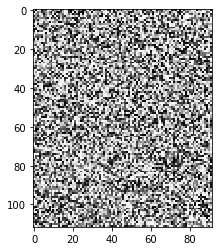

In [69]:
print("Trained Image True Label: {} ({})".format(orig_set.classes[torch.argmax(labels).item()], torch.argmax(labels).item()))

y_pred = net(images)
prob = torch.softmax(y_pred, -1)

# label_name = orig_set.classes[prob.argmax().item()]
# index = prob.argmax().item()

# print("Trained Image Predicted Label: {} ({}) ".format(orig_set.classes[prob.argmax().item()], prob.argmax().item()))
print("Predicted probability for the class: ", prob.max().item())

pic = images.detach().numpy()
# print(pic.shape)
pic_1 = pic[0,0,:,:]
plt.imshow(pic_1, cmap='Greys', interpolation='nearest')